In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    PowerTransformer
)

from sklearn.decomposition import PCA


In [2]:
train_fed = pd.read_csv("train_fed.csv")
test_fed  = pd.read_csv("test_fed.csv")

TARGET = "sii"
y = train_fed[TARGET].copy()
X = train_fed.drop(columns=[TARGET]).copy()
X_test = test_fed.copy()

assert set(X.columns) == set(X_test.columns)
assert X.shape[1] == X_test.shape[1]

print("Loaded FE datasets.")


Loaded FE datasets.


In [3]:
# ===== FIX: drop ID before any transformations =====
drop_cols = []
if "id" in X.columns:
    drop_cols.append("id")

if drop_cols:
    X = X.drop(columns=drop_cols)
    X_test = X_test.drop(columns=drop_cols)
    print("Dropped columns:", drop_cols)


Dropped columns: ['id']


In [4]:
# PART 1 — One-hot encode Season (drop='first')

season_cols = [c for c in X.columns if c.endswith("Season")]
season_dummy_meta = {}

season_train_dums = []
season_test_dums  = []

for col in season_cols:
    categories = sorted(X[col].dropna().unique().tolist())
    season_dummy_meta[col] = categories

    train_cat = pd.Categorical(X[col], categories=categories)
    test_cat  = pd.Categorical(X_test[col], categories=categories)

    train_dum = pd.get_dummies(train_cat, prefix=col, drop_first=True)
    test_dum  = pd.get_dummies(test_cat,  prefix=col, drop_first=True)

    # Align
    test_dum = test_dum.reindex(columns=train_dum.columns, fill_value=0)

    season_train_dums.append(train_dum)
    season_test_dums.append(test_dum)

# Merge & drop originals
X = pd.concat([X.drop(columns=season_cols), pd.concat(season_train_dums, axis=1)], axis=1)
X_test = pd.concat([X_test.drop(columns=season_cols), pd.concat(season_test_dums, axis=1)], axis=1)


In [5]:
# PART 2 — StandardScaler on actigraphy + PAQ_* + SDS_* + CGAS

# Identify groups
act_cols = [c for c in X.columns if any(k in c.lower() for k in 
    ["enmo","anglez","light_","non-wear","battery_voltage","time_of_day",
     "weekday","sedentary_por","moderate_por","active_por",
     "mvpa_minutes_estimate","sedentary_percentage",
     "moderate_vigorous_percentage","screen_vs_activity_ratio"])]

act_cols = [c for c in act_cols if not ("missing" in c.lower() or "flag" in c.lower())]

paq_cols = [c for c in X.columns if "PAQ" in c]
sds_cols = [c for c in X.columns if "SDS" in c]
cgas_cols = [c for c in X.columns if "CGAS" in c]

std_cols = sorted(set(act_cols + paq_cols + sds_cols + cgas_cols))

scaler_std = StandardScaler()
scaler_std.fit(X[std_cols])

X[std_cols] = scaler_std.transform(X[std_cols])
X_test[std_cols] = scaler_std.transform(X_test[std_cols])


In [6]:
# PART 3 — RobustScaler on anthropometrics + BP

anthro_cols = [c for c in X.columns if any(k in c.lower() for k in
    ["bmi","waist","height","weight","systolic","diastolic","pulse","mean_arterial"])]

scaler_robust = RobustScaler()
scaler_robust.fit(X[anthro_cols])

X[anthro_cols] = scaler_robust.transform(X[anthro_cols])
X_test[anthro_cols] = scaler_robust.transform(X_test[anthro_cols])


In [7]:
# PART 4 — Log1p transform

internet_col = "PreInt_EduHx-computerinternet_hoursday"

kurt = X.kurt().fillna(0)
extremely_skewed_cols = [c for c in X.columns if kurt.get(c,0) > 10]

if internet_col not in extremely_skewed_cols:
    extremely_skewed_cols.append(internet_col)

for col in extremely_skewed_cols:
    X[col] = np.log1p(np.clip(X[col], 0, None))
    X_test[col] = np.log1p(np.clip(X_test[col], 0, None))

internet_log_col = internet_col  # log1p applied in-place


In [8]:
# PART 5 — Yeo-Johnson

moderately_skewed = [c for c in X.columns if 3 < kurt.get(c,0) <= 10]
moderately_skewed = [c for c in moderately_skewed if c not in extremely_skewed_cols]

pt_yj = PowerTransformer(method="yeo-johnson", standardize=False)
pt_yj.fit(X[moderately_skewed])

X[moderately_skewed] = pt_yj.transform(X[moderately_skewed])
X_test[moderately_skewed] = pt_yj.transform(X_test[moderately_skewed])


In [9]:
# PART 6 — PCA on actigraphy-derived features

acti_cols_for_pca = act_cols  # already scaled

assert X[acti_cols_for_pca].isna().sum().sum() == 0
assert X_test[acti_cols_for_pca].isna().sum().sum() == 0

pca_tmp = PCA()
pca_tmp.fit(X[acti_cols_for_pca])
cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
n95 = int(np.searchsorted(cum_var, 0.95) + 1)

n_components = min(n95, 20)
pca = PCA(n_components=n_components)
pca.fit(X[acti_cols_for_pca])

# Add PCA columns
X_pca = pca.transform(X[acti_cols_for_pca])
X_test_pca = pca.transform(X_test[acti_cols_for_pca])

for i in range(n_components):
    cname = f"acti_pca_{i:02d}"
    X[cname] = X_pca[:, i]
    X_test[cname] = X_test_pca[:, i]


C:\Users\Admin\AppData\Local\Temp\ipykernel_27124\1012503841.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[cname] = X_pca[:, i]
C:\Users\Admin\AppData\Local\Temp\ipykernel_27124\1012503841.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[cname] = X_test_pca[:, i]
C:\Users\Admin\AppData\Local\Temp\ipykernel_27124\1012503841.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

In [10]:
# PART 7 — POR proportions must sum to 1

por_cols = [c for c in X.columns if c.endswith("_por")]

for df in (X, X_test):
    total = df[por_cols].sum(axis=1).replace(0, np.nan)
    for col in por_cols:
        df[col] = df[col] / total
    df[por_cols] = df[por_cols].fillna(0)


In [11]:
# PART 8 — Interaction features

interaction_cols = []

# a) internet_log × sedentary_por
if internet_log_col in X and "sedentary_por" in X:
    X["internet_x_sedentary"] = X[internet_log_col] * X["sedentary_por"]
    X_test["internet_x_sedentary"] = X_test[internet_log_col] * X_test["sedentary_por"]
    interaction_cols.append("internet_x_sedentary")

# b) ENMO_mean × MVPA_por
if "enmo_mean" in X and "moderate_vigorous_percentage" in X:
    X["enmo_x_mvpa"] = X["enmo_mean"] * X["moderate_vigorous_percentage"]
    X_test["enmo_x_mvpa"] = X_test["enmo_mean"] * X_test["moderate_vigorous_percentage"]
    interaction_cols.append("enmo_x_mvpa")

# c) SDS_total × CGAS
if "SDS-SDS_Total_Raw" in X and "CGAS-CGAS_Score" in X:
    X["SDSxCGAS_raw"] = X["SDS-SDS_Total_Raw"] * X["CGAS-CGAS_Score"]
    X_test["SDSxCGAS_raw"] = X_test["SDS-SDS_Total_Raw"] * X_test["CGAS-CGAS_Score"]
    interaction_cols.append("SDSxCGAS_raw")

# d) BMI × Fat_percentage
if "Physical-BMI" in X and "BIA-BIA_Fat" in X:
    X["BMIxFat"] = X["Physical-BMI"] * X["BIA-BIA_Fat"]
    X_test["BMIxFat"] = X_test["Physical-BMI"] * X_test["BIA-BIA_Fat"]
    interaction_cols.append("BMIxFat")

# e) Age × Endurance
if "Basic_Demos-Age" in X and "Endurance_total_secs" in X:
    X["Age_x_Endurance"] = X["Basic_Demos-Age"] * X["Endurance_total_secs"]
    X_test["Age_x_Endurance"] = X_test["Basic_Demos-Age"] * X_test["Endurance_total_secs"]
    interaction_cols.append("Age_x_Endurance")


C:\Users\Admin\AppData\Local\Temp\ipykernel_27124\1457135845.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["internet_x_sedentary"] = X[internet_log_col] * X["sedentary_por"]
C:\Users\Admin\AppData\Local\Temp\ipykernel_27124\1457135845.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test["internet_x_sedentary"] = X_test[internet_log_col] * X_test["sedentary_por"]
C:\Users\Admin\AppData\Local\Temp\ipykernel_27124\1457135845.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

In [12]:
# PART 9 — Keep missing flags untouched

missing_flags = [c for c in X.columns if "missing" in c.lower() or "flag" in c.lower()]
print("Missingness flags kept:", missing_flags[:10])


Missingness flags kept: ['non-wear_flag_count', 'non-wear_flag_mean', 'non-wear_flag_std', 'non-wear_flag_min', 'non-wear_flag_25%', 'non-wear_flag_50%', 'non-wear_flag_75%', 'non-wear_flag_max', 'FGC-FGC_CU_Zone_missing', 'FGC-FGC_GSND_Zone_missing']


Final shapes: (2736, 287) (20, 287)
Saved final datasets.


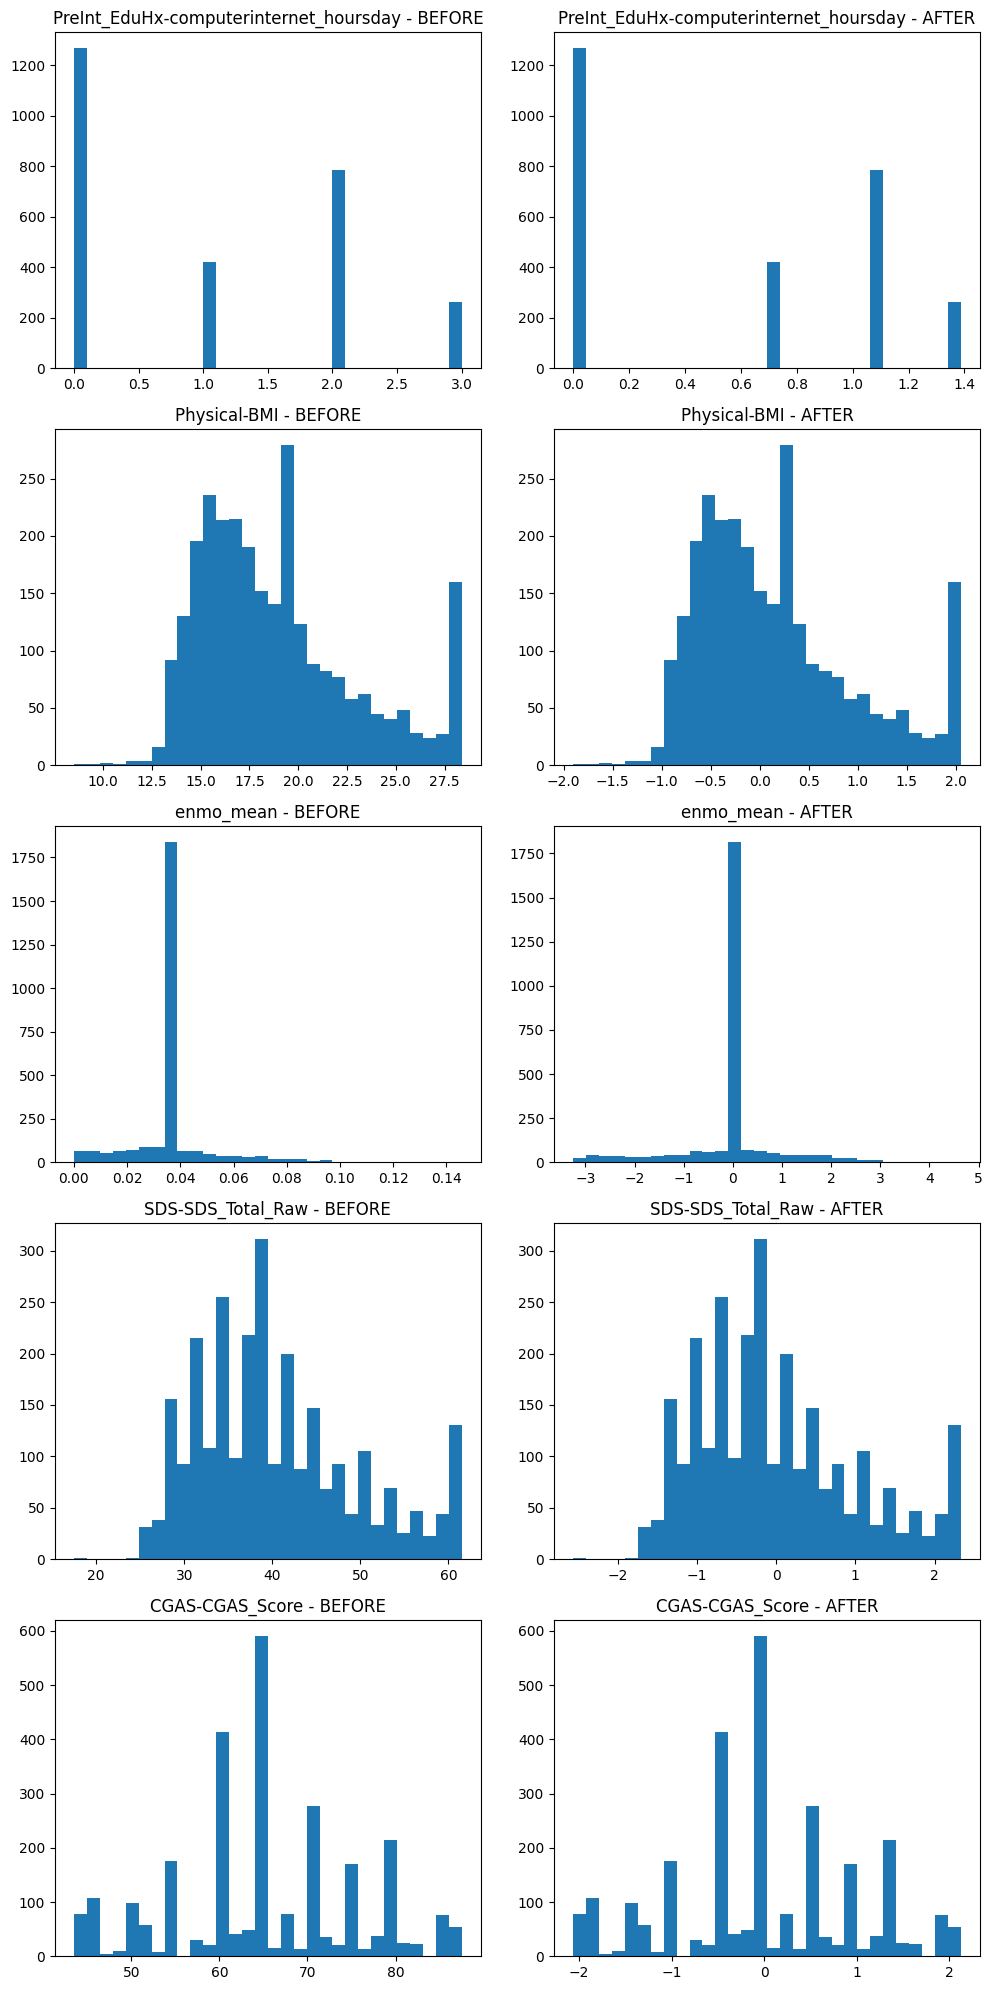

In [13]:
# PART 10 — Sanity checks, plots, save

# Alignment
final_cols = X.columns.tolist()
X_test = X_test.reindex(columns=final_cols, fill_value=0)

assert list(X.columns) == list(X_test.columns), "Column mismatch!"

# NaN check
assert X.isna().sum().sum() == 0, "NaNs in train_final!"
assert X_test.isna().sum().sum() == 0, "NaNs in test_final!"

# Numeric-only finiteness check
num_cols = X.select_dtypes(include=[np.number]).columns
assert np.isfinite(X[num_cols].to_numpy()).all(), "Non-finite in train!"
assert np.isfinite(X_test[num_cols].to_numpy()).all(), "Non-finite in test!"

print("Final shapes:", X.shape, X_test.shape)

# Save datasets
train_final = X.copy()
train_final.insert(0, TARGET, y.values)

train_final.to_csv("train_final.csv", index=False)
X_test.to_csv("test_final.csv", index=False)
print("Saved final datasets.")

# Plots
features = [
    "PreInt_EduHx-computerinternet_hoursday", "Physical-BMI",
    "enmo_mean", "SDS-SDS_Total_Raw", "CGAS-CGAS_Score"
]

fig, ax = plt.subplots(len(features), 2, figsize=(10, 4*len(features)))

for i, f in enumerate(features):
    ax[i,0].hist(train_fed[f], bins=30)
    ax[i,0].set_title(f"{f} - BEFORE")

    ax[i,1].hist(train_final[f], bins=30)
    ax[i,1].set_title(f"{f} - AFTER")

plt.tight_layout()
plt.show()


| **Step**                                                       | **What It Does**                                                                | **Columns Affected**                                                           | **How It Works (Technical)**                                                           | **Why It Matters**                                                              | **Leakage-Safe?**                |
| -------------------------------------------------------------- | ------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------- | -------------------------------- |
| **1. Load `train_final` / `test_final` & split X / y**         | Separates features from labels and ensures consistent shapes.                   | All columns; removes target (`sii`).                                           | `X = train.drop([id_cols + target])` and same for test.                                | Provides clean input for consistent transformations.                                                  | ✔ Yes, no stats computed.        |
| **2. Drop ID columns**                                         | Prevents ID-based leakage / memorization.                                       | `"id"` (or similar)                                                            | `X.drop(columns=['id'])` on both train and test.                                       | Ensures models don’t learn participant-specific patterns.                                             | ✔ Yes                            |
| **3. Identify numeric vs categorical features**                | Creates lists of feature groups for later transforms.                           | All columns                                                                    | `df.select_dtypes(include=['float','int'])`                                            | Prepares consistent, automatic selection for transforms.                                              | ✔ Yes                            |
| **4. Identify skewed numerical features**                      | Finds variables with strong positive skew (often actigraphy, physical metrics). | ENMO, light metrics, anglez, sleep fragmentation, metabolic/clinical features. | `scipy.stats.skew(X[col]) > threshold → skew_cols`                                     | Many PIU actigraphy features follow log-normal distributions; skew correction stabilizes tree splits. | ✔ Yes                            |
| **5. Yeo-Johnson PowerTransformer**                            | Makes skewed variables closer to normal without requiring positive-only data.   | `skew_cols`                                                                    | `pt = PowerTransformer(method='yeo-johnson')`, `pt.fit(X[skew_cols])`, then transform. | Boosted-tree and NN models handle more Gaussian-like features better, reducing variance.              | ✔ Yes → fitted only on train     |
| **6. StandardScaler**                                          | Normalizes continuous clinical and actigraphy features to mean 0 / std 1.       | Actigraphy aggregates, PAQ, SDS, CGAS, fitness/endurance measures.             | `scaler_std.fit(X[std_cols])`, then transform test.                                    | Critical for neural nets and stacking; also improves tree model leaf-split stability.                 | ✔ Yes – train-only fit           |
| **7. RobustScaler**                                            | Scales heavy-tailed or outlier-prone clinical variables.                        | BMI, Waist, Height, Weight, BP_systolic, BP_diastolic, etc.                    | `RobustScaler(with_centering=True).fit(X[anthro_cols])`                                | Highly effective for biometric features with extreme outliers. Reduces influence on splits.           | ✔ Yes                            |
| **8. log1p Transformation**                                    | Stabilizes variance for extreme-positive or zero-heavy features.                | Often ENMO, light, steps, or metabolic-intensity metrics.                      | `np.log1p(x)` applied column-wise.                                                     | Improves handling of exponential-like actigraphy features.                                            | ✔ Yes (row-wise only)            |
| **9. PCA on actigraphy quantiles / high-dimensional subspace** | Reduces dimensionality and denoises correlated actigraphy features.             | Actigraphy quantile features or summary bands (e.g., `ENMO_qXX`, `light_qXX`). | `pca = PCA(n_components=k)` fitted on `X[actigraphy_submatrix]`.                       | Prevents overfitting from extremely correlated wearable metrics; captures “activity signature”.       | ✔ Yes – PCA fitted on train-only |
| **10. Recombine transformed columns**                          | Recreates a full feature matrix with transformed columns inserted.              | All columns in `X_transformed`.                                                | Replace transformation targets and keep untouched columns.                             | Provides complete transformed dataset for modeling.                                                   | ✔ Yes                            |
| **11. Save transformed train/test**                            | Output for downstream modeling (Notebook 6–8).                                  | Entire dataset.                                                                | `train_transformed.to_csv(...)`                                                        | Ensures reproducibility and consistent downstream training.                                           | ✔ Yes                            |
